In [29]:
import pandas as pd
from datetime import datetime

In [30]:
# Load all relevant CSV files
patients = pd.read_csv("csv/patients.csv")
encounters = pd.read_csv("csv/encounters.csv")
conditions = pd.read_csv("csv/conditions.csv")
procedures = pd.read_csv("csv/procedures.csv")
medications = pd.read_csv("csv/medications.csv")
immunizations = pd.read_csv("csv/immunizations.csv")
devices = pd.read_csv("csv/devices.csv")
supplies = pd.read_csv("csv/supplies.csv")

In [31]:
# -------------------------------------
# Step 1: Prepare patient demographic data
# -------------------------------------
patients['Age'] = datetime.now().year - pd.to_datetime(patients['BIRTHDATE']).dt.year
patients_df = patients.rename(columns={
    'Id': 'Patient_ID',
    'GENDER': 'Gender',
    'RACE': 'Race',
    'INCOME': 'Income',
    'STATE': 'Region'
})[['Patient_ID', 'Age', 'Gender', 'Race', 'Income', 'Region']]

In [32]:
encounters.columns

Index(['Id', 'START', 'STOP', 'PATIENT', 'ORGANIZATION', 'PROVIDER', 'PAYER',
       'ENCOUNTERCLASS', 'CODE', 'DESCRIPTION', 'BASE_ENCOUNTER_COST',
       'TOTAL_CLAIM_COST', 'PAYER_COVERAGE', 'REASONCODE',
       'REASONDESCRIPTION'],
      dtype='object')

In [33]:
# -------------------------------------
# Step 2: Aggregate encounter data
# -------------------------------------
encounter_summary = encounters.groupby('PATIENT').agg({
    'TOTAL_CLAIM_COST': ['count', 'mean', 'sum'],
    'ENCOUNTERCLASS': 'last'
}).reset_index()
encounter_summary.columns = ['Patient_ID', 'Number_of_Encounters', 'Avg_Encounter_Cost', 'Total_Encounter_Cost', 'Last_Encounter_Type']

In [34]:
# -------------------------------------
# Step 3: Cost aggregation helper
# -------------------------------------
def cost_aggregate(df, cost_label):
    # If total cost is not available, use the base cost
    if 'TOTAL_COST' not in df.columns:
        df['TOTAL_COST'] = df['BASE_COST']

    # Aggregate costs
    cost_summary = df.groupby('PATIENT').agg({
        'TOTAL_COST': ['count', 'mean', 'sum']
    }).reset_index()
    cost_summary.columns = ['Patient_ID', f'Number_of_{cost_label}', f'Avg_{cost_label}_Cost', f'Total_{cost_label}_Cost']
    return cost_summary

In [35]:
medications.columns

Index(['START', 'STOP', 'PATIENT', 'PAYER', 'ENCOUNTER', 'CODE', 'DESCRIPTION',
       'BASE_COST', 'PAYER_COVERAGE', 'DISPENSES', 'TOTALCOST', 'REASONCODE',
       'REASONDESCRIPTION'],
      dtype='object')

In [36]:
procedures.columns



Index(['START', 'STOP', 'PATIENT', 'ENCOUNTER', 'SYSTEM', 'CODE',
       'DESCRIPTION', 'BASE_COST', 'REASONCODE', 'REASONDESCRIPTION'],
      dtype='object')

In [37]:
immunizations.columns

Index(['DATE', 'PATIENT', 'ENCOUNTER', 'CODE', 'DESCRIPTION', 'BASE_COST'], dtype='object')

In [38]:
procedure_cost = cost_aggregate(procedures, 'Procedure')
medication_cost = cost_aggregate(medications, 'Medication')
immunization_cost = cost_aggregate(immunizations, 'Immunization')

In [39]:

# Step 4: Count conditions
# -------------------------------------
condition_count = conditions.groupby('PATIENT')['CODE'].nunique().reset_index().rename(columns={
    'PATIENT': 'Patient_ID',
    'CODE': 'Number_of_Conditions'
})

# -------------------------------------
# Step 5: Merge everything
# -------------------------------------
final_df = patients_df \
    .merge(encounter_summary, on='Patient_ID', how='left') \
    .merge(procedure_cost, on='Patient_ID', how='left') \
    .merge(medication_cost, on='Patient_ID', how='left') \
    .merge(immunization_cost, on='Patient_ID', how='left') \
    .merge(condition_count, on='Patient_ID', how='left')

# Fill missing cost values with 0
cost_cols = [col for col in final_df.columns if 'Cost' in col]
final_df[cost_cols] = final_df[cost_cols].fillna(0)

# Show or save result
print(final_df.head())
# final_df.to_csv("combined_ehr_cost_dataset.csv", index=False)

                             Patient_ID  Age Gender   Race  Income  \
0  18dd2533-bb7f-5534-9a76-a4395c37754a    1      M  white  192607   
1  d4569339-77c8-1560-4a22-fd5f6e06f4bd    6      M  white   60531   
2  9e51f293-03a2-a5e9-13b3-65d3dedc6898   17      M  white  164360   
3  1e504040-6736-5eb0-bbe3-cc52f9384335   20      F  white   28119   
4  153186d1-e65b-3472-3531-c31ea5473edd   22      M  white   23857   

          Region  Number_of_Encounters  Avg_Encounter_Cost  \
0  Massachusetts                     6          698.658333   
1  Massachusetts                    16          600.203750   
2  Massachusetts                    16         1338.195625   
3  Massachusetts                    19         1147.697368   
4  Massachusetts                    13         1450.994615   

   Total_Encounter_Cost Last_Encounter_Type  Number_of_Procedure  \
0               4191.95            wellness                  4.0   
1               9603.26            wellness                  9.0   
2 

In [40]:
final_df.head()

,Patient_ID,Age,Gender,Race,Income,Region,Number_of_Encounters,Avg_Encounter_Cost,Total_Encounter_Cost,Last_Encounter_Type,Number_of_Procedure,Avg_Procedure_Cost,Total_Procedure_Cost,Number_of_Medication,Avg_Medication_Cost,Total_Medication_Cost,Number_of_Immunization,Avg_Immunization_Cost,Total_Immunization_Cost,Number_of_Conditions
0,18dd2533-bb7f-5534-9a76-a4395c37754a,1,M,white,192607,Massachusetts,6,698.658333,4191.95,wellness,4.0,258.955000,1035.82,NaN,0.00,0.00,17.0,136.0,2312.0,2
1,d4569339-77c8-1560-4a22-fd5f6e06f4bd,6,M,white,60531,Massachusetts,16,600.203750,9603.26,wellness,9.0,326.802222,2941.22,6.0,129.94,779.64,32.0,136.0,4352.0,6
2,9e51f293-03a2-a5e9-13b3-65d3dedc6898,17,M,white,164360,Massachusetts,16,1338.195625,21411.13,wellness,50.0,503.075800,25153.79,1.0,129.94,129.94,16.0,136.0,2176.0,6
3,1e504040-6736-5eb0-bbe3-cc52f9384335,20,F,white,28119,Massachusetts,19,1147.697368,21806.25,wellness,71.0,387.892958,27540.40,5.0,373.13,1865.65,17.0,136.0,2312.0,11
4,153186d1-e65b-3472-3531-c31ea5473edd,22,M,white,23857,Massachusetts,13,1450.994615,18862.93,ambulatory,67.0,405.521940,27169.97,1.0,129.94,129.94,13.0,136.0,1768.0,9


In [41]:
final_df.to_csv("csv/combined_ehr_cost_dataset.csv", index=False)

In [42]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11473 entries, 0 to 11472
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Patient_ID               11473 non-null  object 
 1   Age                      11473 non-null  int32  
 2   Gender                   11473 non-null  object 
 3   Race                     11473 non-null  object 
 4   Income                   11473 non-null  int64  
 5   Region                   11473 non-null  object 
 6   Number_of_Encounters     11473 non-null  int64  
 7   Avg_Encounter_Cost       11473 non-null  float64
 8   Total_Encounter_Cost     11473 non-null  float64
 9   Last_Encounter_Type      11473 non-null  object 
 10  Number_of_Procedure      11455 non-null  float64
 11  Avg_Procedure_Cost       11473 non-null  float64
 12  Total_Procedure_Cost     11473 non-null  float64
 13  Number_of_Medication     11216 non-null  float64
 14  Avg_Medication_Cost   

In [43]:
final_df.describe()

,Age,Income,Number_of_Encounters,Avg_Encounter_Cost,Total_Encounter_Cost,Number_of_Procedure,Avg_Procedure_Cost,Total_Procedure_Cost,Number_of_Medication,Avg_Medication_Cost,Total_Medication_Cost,Number_of_Immunization,Avg_Immunization_Cost,Total_Immunization_Cost,Number_of_Conditions
count,11473.000000,11473.000000,11473.000000,11473.000000,1.147300e+04,11455.000000,11473.000000,1.147300e+04,11216.000000,11473.000000,11473.000000,11461.000000,11473.000000,11473.000000,11473.000000
mean,45.024492,120404.406432,59.623987,2734.971366,1.649210e+05,164.872807,898.668229,1.623922e+05,52.798948,167.750239,5367.766263,14.465230,135.857753,1965.213632,19.770853
std,26.220152,177344.116432,93.042236,2861.402802,2.811424e+05,211.759104,773.461433,2.814439e+05,146.797550,752.148089,15946.708244,6.259592,4.396253,853.232326,9.957627
min,0.000000,3.000000,1.000000,235.243333,3.473800e+02,1.000000,0.000000,0.000000e+00,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
25%,24.000000,31954.000000,24.000000,1241.677000,3.361813e+04,69.000000,446.741190,3.468182e+04,5.000000,71.057363,547.920000,11.000000,136.000000,1496.000000,13.000000
50%,44.000000,69218.000000,36.000000,1809.091875,7.563219e+04,115.000000,576.864259,7.332088e+04,12.000000,116.179324,1420.200000,13.000000,136.000000,1768.000000,19.000000
75%,63.000000,126380.000000,57.000000,3228.860465,1.922238e+05,171.500000,1009.888015,1.832789e+05,35.000000,152.872500,3403.500000,16.000000,136.000000,2176.000000,25.000000
max,111.000000,995933.000000,909.000000,38499.014545,4.234892e+06,2162.000000,7713.844289,4.222189e+06,3086.000000,34898.286667,432681.340000,37.000000,136.000000,5032.000000,70.000000


In [44]:
final_df["Number_of_Procedure"]= final_df["Number_of_Procedure"].fillna(0)
final_df["Number_of_Medication"]= final_df["Number_of_Medication"].fillna(0)
final_df["Number_of_Immunization"]= final_df["Number_of_Immunization"].fillna(0)
final_df["Number_of_Encounters"]= final_df["Number_of_Encounters"].fillna(0)
final_df["Number_of_Conditions"]= final_df["Number_of_Conditions"].fillna(0)
final_df["Avg_Procedure_Cost"]= final_df["Avg_Procedure_Cost"].fillna(0)
final_df["Avg_Medication_Cost"]= final_df["Avg_Medication_Cost"].fillna(0)
final_df["Avg_Immunization_Cost"]= final_df["Avg_Immunization_Cost"].fillna(0)
final_df["Avg_Encounter_Cost"]= final_df["Avg_Encounter_Cost"].fillna(0)
final_df["Total_Procedure_Cost"]= final_df["Total_Procedure_Cost"].fillna(0)
final_df["Total_Medication_Cost"]= final_df["Total_Medication_Cost"].fillna(0)
final_df["Total_Immunization_Cost"]= final_df["Total_Immunization_Cost"].fillna(0)
final_df["Total_Encounter_Cost"]= final_df["Total_Encounter_Cost"].fillna(0)

In [45]:
final_df = pd.get_dummies(final_df, columns=['Gender', 'Race', 'Region', 'Last_Encounter_Type'], drop_first=True)


In [46]:
final_df.head()

,Patient_ID,Age,Income,Number_of_Encounters,Avg_Encounter_Cost,Total_Encounter_Cost,Number_of_Procedure,Avg_Procedure_Cost,Total_Procedure_Cost,Number_of_Medication,...,Race_white,Last_Encounter_Type_emergency,Last_Encounter_Type_home,Last_Encounter_Type_hospice,Last_Encounter_Type_inpatient,Last_Encounter_Type_outpatient,Last_Encounter_Type_snf,Last_Encounter_Type_urgentcare,Last_Encounter_Type_virtual,Last_Encounter_Type_wellness
0,18dd2533-bb7f-5534-9a76-a4395c37754a,1,192607,6,698.658333,4191.95,4.0,258.955000,1035.82,0.0,...,True,False,False,False,False,False,False,False,False,True
1,d4569339-77c8-1560-4a22-fd5f6e06f4bd,6,60531,16,600.203750,9603.26,9.0,326.802222,2941.22,6.0,...,True,False,False,False,False,False,False,False,False,True
2,9e51f293-03a2-a5e9-13b3-65d3dedc6898,17,164360,16,1338.195625,21411.13,50.0,503.075800,25153.79,1.0,...,True,False,False,False,False,False,False,False,False,True
3,1e504040-6736-5eb0-bbe3-cc52f9384335,20,28119,19,1147.697368,21806.25,71.0,387.892958,27540.40,5.0,...,True,False,False,False,False,False,False,False,False,True
4,153186d1-e65b-3472-3531-c31ea5473edd,22,23857,13,1450.994615,18862.93,67.0,405.521940,27169.97,1.0,...,True,False,False,False,False,False,False,False,False,False


In [47]:
from sklearn.preprocessing import StandardScaler

features_to_scale = [
    'Age', 'Income', 'Number_of_Encounters', 'Avg_Encounter_Cost',
    'Number_of_Procedure', 'Avg_Procedure_Cost',
    'Number_of_Medication', 'Avg_Medication_Cost',
    'Number_of_Immunization', 'Avg_Immunization_Cost',
    'Number_of_Conditions'
]

scaler = StandardScaler()
final_df[features_to_scale] = scaler.fit_transform(final_df[features_to_scale])


In [48]:
# Simple additive score (normalize to z-scores first)
from scipy.stats import zscore
cost_z = zscore(final_df['Total_Encounter_Cost'])
cond_z = zscore(final_df['Number_of_Conditions'])

final_df['Risk_Score'] = cost_z + cond_z

risk_labels = pd.qcut(final_df['Risk_Score'], q=3, labels=['Low', 'Medium', 'High'])
final_df['Combined_Risk_Level'] = risk_labels


In [49]:
print(final_df['Combined_Risk_Level'].value_counts())


Combined_Risk_Level
High      3825
Low       3824
Medium    3824
Name: count, dtype: int64


In [50]:
final_df

,Patient_ID,Age,Income,Number_of_Encounters,Avg_Encounter_Cost,Total_Encounter_Cost,Number_of_Procedure,Avg_Procedure_Cost,Total_Procedure_Cost,Number_of_Medication,...,Last_Encounter_Type_home,Last_Encounter_Type_hospice,Last_Encounter_Type_inpatient,Last_Encounter_Type_outpatient,Last_Encounter_Type_snf,Last_Encounter_Type_urgentcare,Last_Encounter_Type_virtual,Last_Encounter_Type_wellness,Risk_Score,Combined_Risk_Level
0,18dd2533-bb7f-5534-9a76-a4395c37754a,-1.679106,0.407150,-0.576365,-0.711680,4191.95,-0.758744,-0.827114,1035.82,-0.355122,...,False,False,False,False,False,False,False,True,-2.356450,Low
1,d4569339-77c8-1560-4a22-fd5f6e06f4bd,-1.488405,-0.337626,-0.468883,-0.746089,9603.26,-0.735124,-0.739392,2941.22,-0.313842,...,False,False,False,False,False,False,False,True,-1.935482,Low
2,9e51f293-03a2-a5e9-13b3-65d3dedc6898,-1.068862,0.247866,-0.468883,-0.488165,21411.13,-0.541439,-0.511480,25153.79,-0.348242,...,False,False,False,False,False,False,False,True,-1.893481,Low
3,1e504040-6736-5eb0-bbe3-cc52f9384335,-0.954441,-0.520397,-0.436638,-0.554743,21806.25,-0.442235,-0.660405,27540.40,-0.320722,...,False,False,False,False,False,False,False,True,-1.389925,Low
4,153186d1-e65b-3472-3531-c31ea5473edd,-0.878160,-0.544431,-0.501127,-0.448742,18862.93,-0.461131,-0.637611,27169.97,-0.348242,...,False,False,False,False,False,False,False,False,-1.601255,Low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11468,e8ca3ae7-3379-801a-9286-6195f170dd01,1.906079,1.682551,-0.210924,0.333559,147575.03,0.096303,-0.205331,136874.08,-0.107440,...,False,False,False,False,False,False,False,True,-0.139118,Medium
11469,927cf390-0454-aeb2-876a-2483e02515fa,1.600957,0.159356,2.132200,-0.457522,367875.14,5.028176,-0.598941,535144.48,2.238657,...,False,False,False,False,False,True,False,False,2.452244,High
11470,550270cd-3092-b715-af62-65345241a4f7,1.906079,1.682551,1.519548,-0.258307,401172.48,4.773079,-0.574477,533863.12,3.972430,...,False,False,False,False,False,False,False,True,2.470255,High
11471,9877b244-ef7d-8938-4d2b-07ba6d54d91f,1.906079,1.682551,5.270696,-0.510704,700537.18,5.576162,-0.421567,770169.75,4.715475,...,False,False,False,False,False,False,False,True,5.041565,High


In [51]:
# Drop unnecessary columns for features (you may keep Age, Income, and engineered features)
X = final_df.drop([
    'Patient_ID', 'Total_Encounter_Cost',
    'Risk_Score', 'Combined_Risk_Level'
], axis=1)

# Encode the risk labels for classification
y = final_df['Combined_Risk_Level']


In [52]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [53]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)


In [54]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

        High       0.97      0.97      0.97       765
         Low       0.99      0.98      0.99       765
      Medium       0.95      0.96      0.95       765

    accuracy                           0.97      2295
   macro avg       0.97      0.97      0.97      2295
weighted avg       0.97      0.97      0.97      2295

[[742   0  23]
 [  0 751  14]
 [ 26   8 731]]


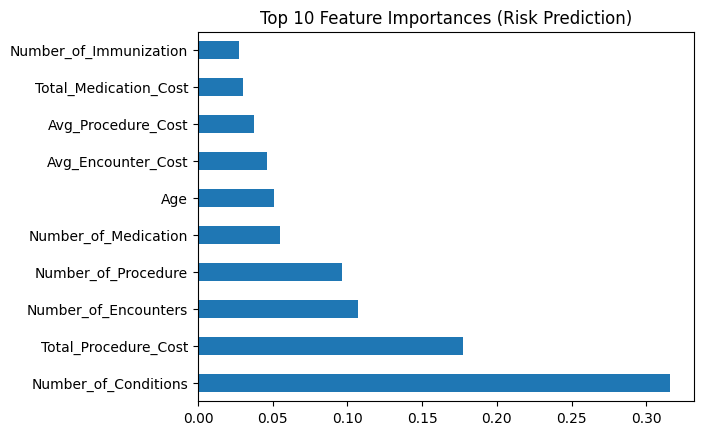

In [55]:
import matplotlib.pyplot as plt

feat_importances = pd.Series(clf.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.title("Top 10 Feature Importances (Risk Prediction)")
plt.show()


In [56]:
import joblib
joblib.dump(clf, 'risk_classifier.joblib')
# Also save your scaler if you used one
joblib.dump(scaler, 'feature_scaler.joblib')

['feature_scaler.joblib']

In [57]:
# After pd.get_dummies(...)
feature_names = X.columns.tolist()
import joblib
joblib.dump(feature_names, 'feature_names.joblib')


['feature_names.joblib']